# Modeling

This notebook combines the three cleaned datasets into one central location and aggregates them before conducting data engineering and running a wide array of models to determine the final top performer and understand the relationships between the features.

## Data Imporrts

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Importing databases using SQL
from sqlalchemy import create_engine

# Model preprocessing and processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.base import clone

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Performance evaluation
from sklearn.metrics import f1_score,precision_score,accuracy_score,recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Data visualization
import shap

# Options
#pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
%matplotlib inline

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../src')

# Custom functions
from create_target import *
from remove_missing_data import *
from evaluate_model_performance import *
from custom_plots import *

# Global constants
RANDOM_STATE = 2021

##### Import "Protests" dataset

In [2]:
engine = create_engine('sqlite:///../data/processed/protests.db')
with engine.begin() as connection:
    df_protests = pd.read_sql('SELECT * FROM protests', con=connection)

# Type casting
df_protests.startdate = pd.to_datetime(df_protests.startdate)

##### Import "Governments" dataset

In [3]:
engine = create_engine('sqlite:///../data/processed/governments.db')
with engine.begin() as connection:
    df_govts = pd.read_sql('SELECT * FROM governments', con=connection)

# Set index to be used on Join later
df_govts.index = df_govts.year_scode

# Remove unused features
df_govts.drop('year_scode', axis=1, inplace=True)

##### Join "Protests" and "Governments" datasets

In [4]:
# Join both dataframes
df = df_protests.join(df_govts, how='left', on='year_scode')

# Remove entries that don't have corresponding 'government' data
df.dropna(inplace=True)

##### Import "Regime Changes" dataset

In [5]:
# IMPORT REGIME CHANGE DATASET
engine = create_engine('sqlite:///../data/processed/regime_changes.db')
with engine.begin() as connection:
    df_regimes = pd.read_sql('SELECT * FROM regime_changes', con=connection)

# Type conversions
df_regimes.startdate = pd.to_datetime(df_regimes.startdate)
df_regimes.enddate = pd.to_datetime(df_regimes.enddate)
df_regimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   country       1296 non-null   object        
 1   scode         1296 non-null   object        
 2   startdate     1296 non-null   datetime64[ns]
 3   enddate       1296 non-null   datetime64[ns]
 4   duration_yrs  1296 non-null   float64       
 5   parcomp       1296 non-null   int64         
 6   parreg        1296 non-null   int64         
 7   xconst        1296 non-null   int64         
 8   xropen        1296 non-null   int64         
 9   xrcomp        1296 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(2)
memory usage: 101.4+ KB


##### QC that country names and country IDs match

In [6]:
cols = ['scode', 'scode_govt', 'country', 'country_govt']
missing_countries = df.loc[(df.country != df.country_govt)][cols]
missing_countries = missing_countries.drop_duplicates()
display(missing_countries.sort_values(by='scode'))

,scode,scode_govt,country,country_govt


##### Remove countries that do not contain government data

In [7]:
scodes_to_remove = missing_countries.scode.unique()
scodes_to_remove_ind = [x in scodes_to_remove for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

##### Identify countries that are missing from "Regime Changes" dataset

In [8]:
# All countries in union of Protests and Governments
all_countries = df.scode.unique()

# All countries in Regimes
regime_countries = df_regimes.scode.unique()


# Loop over all_countries
missing = []
for country in all_countries:
    # Make note of any countries not in Regimes
    
    if country not in regime_countries:
        missing.append(country)

print('Countries missing from "Regimes" dataset:', missing)

# Remove these countries from dataset
scodes_to_remove_ind = [x in missing for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

Countries missing from "Regimes" dataset: ['LUX']


#### Create "Target" column and add to dataframe

In [9]:
# Reimport in one location for easy QC as src file is updated
target = create_target(df, df_regimes)
df = pd.concat([df, target], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15207 entries, 0 to 15207
Data columns (total 81 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   index                              15061 non-null  float64       
 1   country                            15061 non-null  object        
 2   scode                              15061 non-null  object        
 3   region                             15061 non-null  object        
 4   protestnumber                      15061 non-null  float64       
 5   protesterviolence                  15061 non-null  float64       
 6   startdate                          15061 non-null  datetime64[ns]
 7   duration_days                      15061 non-null  float64       
 8   participants                       15061 non-null  float64       
 9   participants_category              15061 non-null  object        
 10  demand_labor-wage-dispute         

### Basic cleaning

In [10]:
# Convert startdate to a float instead of datetime since datetime 
# cannot be handled by models but fractional years can
df['startdate'] = df.startdate.dt.year + \
                  df.startdate.dt.month/12 + \
                  df.startdate.dt.day/365

##### Run custom function that removes all features that don't have a minimum threshold of non-null values

In [11]:
df = remove_missing_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14787 entries, 0 to 15060
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   index                              14787 non-null  float64       
 1   country                            14787 non-null  object        
 2   scode                              14787 non-null  object        
 3   region                             14787 non-null  object        
 4   protestnumber                      14787 non-null  float64       
 5   protesterviolence                  14787 non-null  float64       
 6   startdate                          14787 non-null  float64       
 7   duration_days                      14787 non-null  float64       
 8   participants                       14787 non-null  float64       
 9   participants_category              14787 non-null  object        
 10  demand_labor-wage-dispute         

# Modeling

Given the cleaned and aggregated dataset above, the next section moves into the Modeling phase. Each model type is constructed using elements of encoding, scaling, resampling and hyperparameter optimization.

- One hot encoding was essential given the categorical type of some features
- Standard scaling was essential given the vast array of different numerical feature distributions and ranges. Min-max scaling was considered but proved less effective.
- SMOTE was determined to be essential given the imbalanced nature of the dataset. Only 11% of the target feature values were 1, leaving the other 89% as 0. This is a prime example of the need for resampling, and SMOTE proved highly effective.
- Hyperparameter grid searches are inherently valuable when optimizing a model. Appropriate hyperparameter searches were used for each model type.

The output of each model is provided in terms of four core statistical measures (f1 score, accuracy, precision, and recall), in addition to displaying a confusion matrix for the test data. F1 was selected before the modeling process as the most relevant metric given that it encomasses all possible outcomes, as opposed to the other three metrics which leave out at least one possible outcome from their evaluation. 

Note that the final holdout dataset is not used for evaluation until the final model has been selected based on train-test data performance.

##### Define target


This allows the user to define the target in terms of the number of days before which a regime transition will occur. For this analysis, it uses 365, but other values have also been explored with similar results.

In [12]:
DAYS_UNTIL_CHG = 365
target = pd.DataFrame(df['days_until_next_regime_chg'] < DAYS_UNTIL_CHG)
target = target.astype('int')
target.columns = ['target']

##### Drop unused columns

In [13]:
drop_cols = ['year_scode', 'scode_govt', 'country_govt', 
             'days_until_next_regime_chg', 'scode', 'participants_category', 
             'next_regime_chg_date', 'index', 'duration_days']
model_inputs = df.drop(drop_cols, axis=1)
model_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14787 entries, 0 to 15060
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            14787 non-null  object 
 1   region                             14787 non-null  object 
 2   protestnumber                      14787 non-null  float64
 3   protesterviolence                  14787 non-null  float64
 4   startdate                          14787 non-null  float64
 5   participants                       14787 non-null  float64
 6   demand_labor-wage-dispute          14787 non-null  float64
 7   demand_land-farm-issue             14787 non-null  float64
 8   demand_police-brutality            14787 non-null  float64
 9   demand_political-behavior/process  14787 non-null  float64
 10  demand_price-increases/tax-policy  14787 non-null  float64
 11  demand_removal-of-politician       14787 non-null  flo

##### Standard train-test splits

In [14]:
x_traintest, x_holdout, y_traintest, y_holdout = train_test_split(model_inputs, 
                                                     target, 
                                                     random_state=RANDOM_STATE, 
                                                     test_size=0.3)
x_train, x_test, y_train, y_test = train_test_split(x_traintest, 
                                                    y_traintest, 
                                                    random_state=RANDOM_STATE, 
                                                    test_size=0.3)

### Define models and parameter grids

Define all models and grids in one place. A pipeline structure is created such that each of these models can be run with the below-defined hyperparameter tuning grids alongside their resampling, scaling and encoding. This allows for minimal repetition in code and a consistent structure.

In [15]:
# Set parameter grid to search across
grid_bay = {'model__var_smoothing': [1e-9]}

grid_log = {'model__C': np.logspace(-1, 5, 20)}

grid_dt = {
    #'model__max_depth': [3, 5, 7], 
    #'model__criterion': ['gini', 'entropy'],
    #'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [5, 10]} 

grid_rf = {
    #'model__n_estimators': [25, 75],#, 150],
    #'model__criterion': ['gini', 'entropy'],
    #'model__max_depth': [3, 7],# [3, 6, 10],
    #'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}

grid_knn = {
    #'model__leaf_size': [25, 50, 75],
    #'model__n_neighbors': [3, 5, 7, 9]}#,
    'model__weights': ['uniform', 'distance']}      

grid_ada = {
    #'model__n_estimators': [50, 200],
    'model__learning_rate': [0.1, 0.25, 1]}

grid_xgb = {
#    'model__learning_rate': [0.1, 0.25, 1],
#    'model__max_depth': [3, 5, 7, None],
#    'model__min_child_weight': [1, 2, None],
#    'model__subsample': [0.4, 0.6, 0.8, 1],
#    'model__n_estimators': [50, 100, 150, 200, 250],
    'model__tree_method': ['exact', 'approx', 'hist']}

np.random.seed(RANDOM_STATE)
model_bay = GaussianNB()
model_log = LogisticRegression(max_iter=5000)
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_ada = AdaBoostClassifier(random_state=RANDOM_STATE)
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, 
                          random_state=RANDOM_STATE)

grids = [grid_bay, grid_log, grid_dt, grid_rf, grid_knn, grid_ada, grid_xgb]
models = [model_bay, model_log, model_dt, model_rf, model_knn, model_ada, model_xgb]

#### Pipeline function

This high-level function wraps all the different components of the model pipeline into one location, applying one-hot encoding, standard scaling, smote resampling, and grid searches to the input model. It also outputs performance in the form of standard metrics and a confusion matrix.

In [16]:
def create_pipeline_and_run(model, grid, metric='accuracy'):
    np.random.seed(RANDOM_STATE)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    scaler = StandardScaler()
    smote = SMOTE(random_state=RANDOM_STATE)

    selector_object = make_column_selector(dtype_include='object')
    selector_numeric = make_column_selector(dtype_include='number')
    transformer = make_column_transformer((ohe, selector_object),
                                         (scaler, selector_numeric))


    pipe = Pipeline([('transformer', transformer),
                     ('smote', smote), 
                     ('model', model)])

    # Instantiate and fit grid search object
    grid = GridSearchCV(pipe, grid, scoring='f1', cv=3)
    grid.fit(x_train, y_train)
    pred = grid.best_estimator_.predict(x_test)
    
    
    print(f'{model}:')
    print_scores(pred, y_test)
    
    # Confusion matrix
    plt.figure()
    plot_confusion_matrix(grid.best_estimator_, x_test, y_test)
    plt.show();
    
    return grid.best_estimator_

#### Dummy classifier as performance baseline

In [17]:
for strategy in ["stratified", "uniform", "most_frequent"]:
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(x_train, y_train)
    
    print(f'DUMMY SCORE ({strategy}):')
    pred = dummy_clf.predict(x_test)
    print_scores(pred, y_test)

DUMMY SCORE (stratified):
- f1: 0.08498583569405099
- accuracy: 0.7919484702093398
- precision: 0.08823529411764706
- recall: 0.08196721311475409
DUMMY SCORE (uniform):
- f1: 0.20051948051948051
- accuracy: 0.5043478260869565
- precision: 0.12379730596536241
- recall: 0.5273224043715847
DUMMY SCORE (most_frequent):
- f1: 0.0
- accuracy: 0.8821256038647343
- precision: 0.0
- recall: 0.0


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


### Run *all models* defined above

Run this cell to output the performance of all above-defined models in one place for a side-by-side comparison

In [18]:
# pipes = []
# for grid, model in zip(grids, models):
#     pipe = create_pipeline_and_run(model, grid)
#     pipes.append(pipe)

### Run *only one* model

Choose which model to run in the below cell (used for iterative testing and investigating model specifics without running all models)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=2021, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None):
- f1: 0.7264296754250387
- accuracy: 0.9429951690821256
- precision: 0.8362989323843416
- recall: 0.6420765027322405


<Figure size 432x288 with 0 Axes>

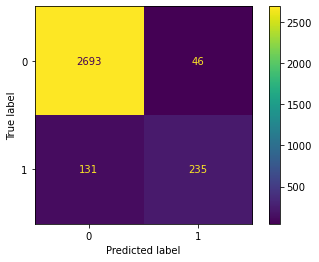

In [19]:
xgb = create_pipeline_and_run(model_xgb, grid_xgb);

#### Test model on holdout dataset

XG bosst proves to be the highest performing model. Test its performance on the holdout dataset.

- f1: 0.7235421166306696
- accuracy: 0.9423033581248591
- precision: 0.8769633507853403
- recall: 0.6158088235294118


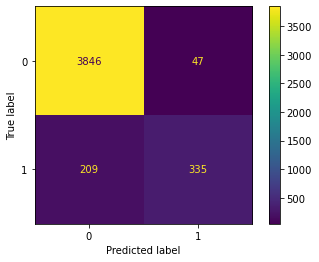

In [25]:
# Predict output
pred = xgb.predict(x_holdout)

# Show performance
print_scores(pred, y_holdout)
plot_confusion_matrix(xgb, x_holdout, y_holdout);

- f1: 0.7235421166306696
- accuracy: 0.9423033581248591
- precision: 0.8769633507853403
- recall: 0.6158088235294118


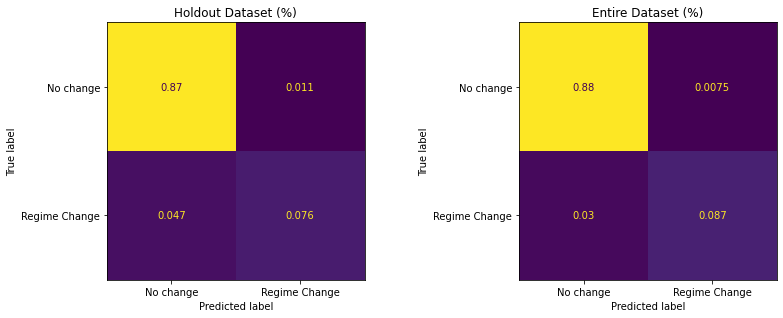

In [79]:
# Predict output
pred = xgb.predict(x_holdout)

# Show performance
print_scores(pred, y_holdout)

# Plot test data and full data performance
labels = ['No change', 'Regime Change']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
plt.subplots_adjust(wspace=0.6, hspace=None)
axes[0].set_title('Holdout Dataset (%)')
axes[1].set_title('Entire Dataset (%)')

plot_confusion_matrix(xgb, x_holdout, y_holdout, ax=axes[0], display_labels=labels, colorbar=False, normalize='all')
plot_confusion_matrix(xgb, model_inputs, target, ax=axes[1], display_labels=labels, colorbar=False, normalize='all');

plt.savefig('../images/confusion_matrices.png')

### Feature importance

Evaluate the feature importance in the top-performing model

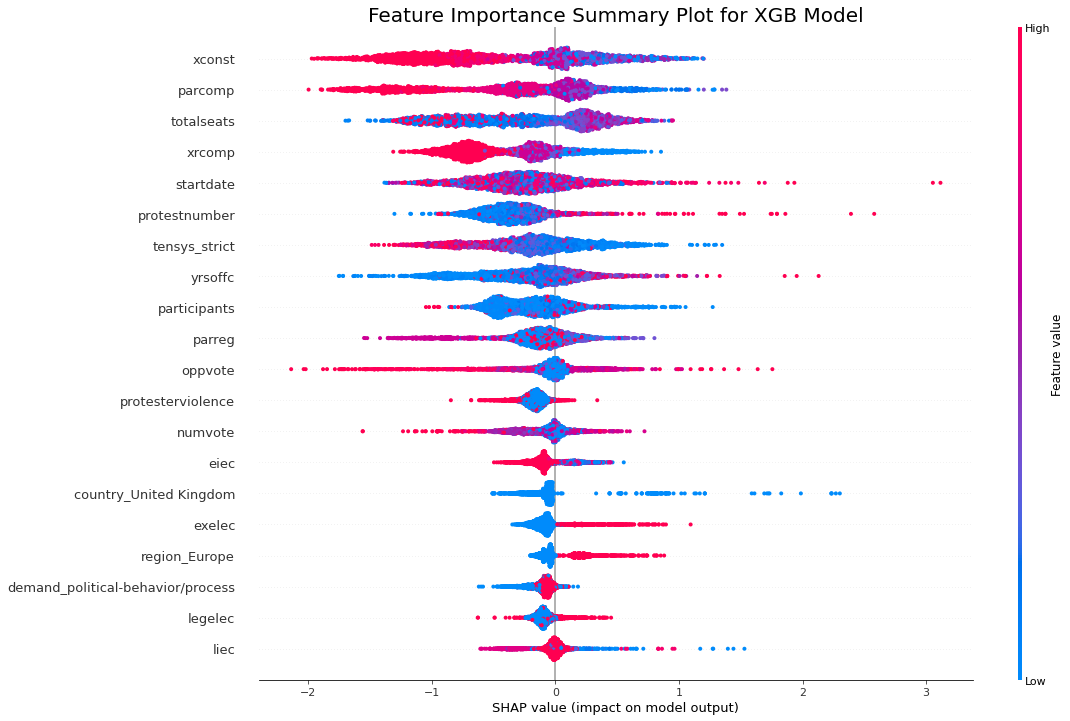

In [85]:
# SHAP summary plot for XGB
produce_shap_plot(x_train, y_train, x_test, y_test, clone(xgb), 
                  title='Feature Importance Summary Plot for XGB Model', 
                  savepath = '../images/shap_summary_plot.png');

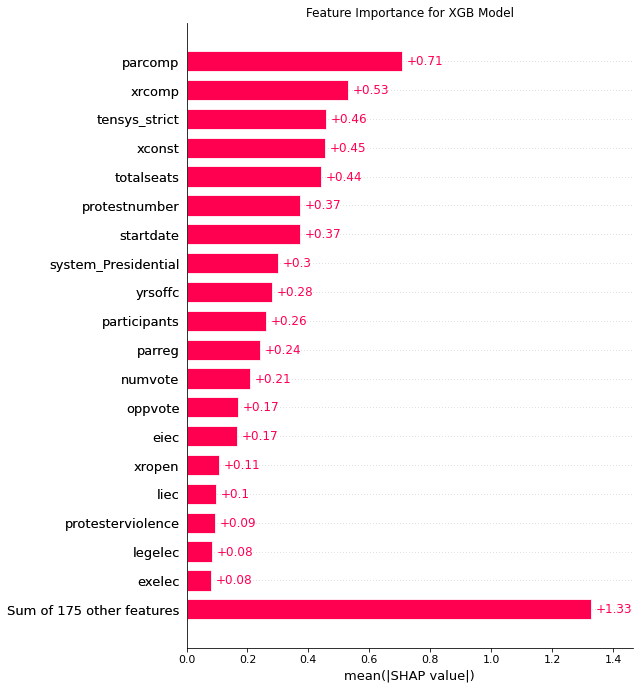

In [22]:
# SHAP bar plot for XGB model
model = xgb.steps[2][1]
x_train_final, y_train_final, df_test_expanded_scaled = get_shap_df(x_train, 
                                                                    y_train, 
                                                                    x_test)

explainer = shap.Explainer(model)
plt.title('Feature Importance for XGB Model')
shap_values = explainer(df_test_expanded_scaled)
shap.plots.bar(shap_values, max_display=20)

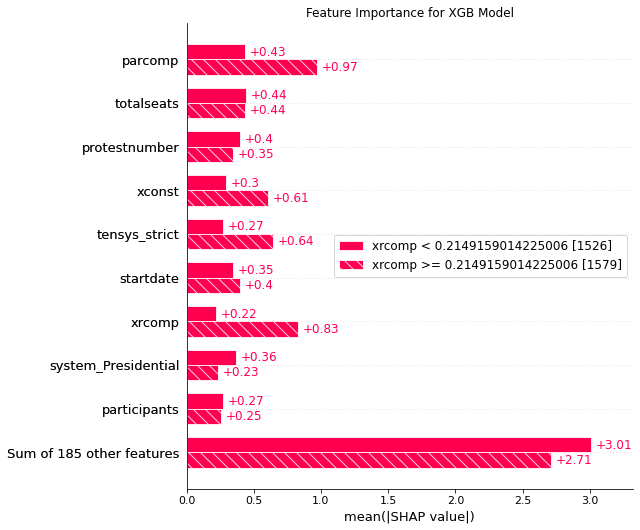

In [23]:
# Source: 
# shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html
plt.title('Feature Importance for XGB Model')
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

## Export to SQL

Export data for analysis in separate EDA file

In [24]:
engine = create_engine('sqlite:///../data/processed/all_data.db')

model_data = pd.concat([model_inputs, target], axis=1)

with engine.begin() as connection:
    model_data.to_sql(name='all_modeled_data', 
                      con=connection, 
                      if_exists='replace', 
                      index=False)